### Word2vec 结合keras

In [1]:
import numpy as np
import sys
import re
import codecs
import os
import jieba
import gensim, logging
from gensim.models import word2vec
from sklearn.cross_validation import train_test_split
from sklearn.externals import joblib
from sklearn.preprocessing import scale
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from scipy import stats
from scipy.stats import ks_2samp 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
from sklearn.metrics import f1_score
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
#from bayes_opt import BayesianOptimization as BO
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score as auc
import matplotlib.pyplot as plt
import sklearn
import jieba

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
W2Vmodel = word2vec.Word2Vec.load("W2Vmodel\CommentsW2V.model")

In [3]:
def getWordVecs(wordList):
    vecs = []
    for word in wordList:
        word = word.replace('\n', '')
        try:
            vecs.append(W2Vmodel[word])
        except KeyError:
            continue
    return np.array(vecs, dtype = 'float')

In [4]:
def buildWordVec(filename):
    posInput = []
    #"SegComments-utf8.txt"
    with open(filename, "r", encoding="utf8") as txtfile:
        for line in txtfile:
            if not line.strip():   # erase null string
                continue
            line = line.split(' ')[2:]    # erase heading null
            line = line[:-1] #+ [line[-1].replace('\n','')] # erase ending char'\n'
            resultList = getWordVecs(line)
            #print(line)
            #print(resultList)
            if len(resultList) > 0:
                resultArray = sum(np.array(resultList))/len(resultList)
                #print( resultArray)
                posInput.append(resultArray)
    return posInput

In [14]:
# posInput = buildWordVec("SegCommentsPosUTF8.txt")
# negInput = buildWordVec("SegCommentsNegUTF8.txt")
posInput = buildWordVec("inputs\TrainNeg.txt")
negInput = buildWordVec("inputs\TrainPos.txt")

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [15]:
# use 1 for positive sentiment, 0 for negative

y = np.concatenate((np.ones(len(posInput)), np.zeros(len(negInput))))
y

array([1., 1., 1., ..., 0., 0., 0.])

In [16]:
X = posInput[:]
                   
for neg in negInput:
    X.append(neg)

X = np.array(X)
#X

In [17]:
# standardization
X=scale(X)
#X

In [18]:
X_reduced = PCA(n_components = 100).fit_transform(X)
#(X_reduced)

In [19]:
# train model
X_reduced_train,X_reduced_test, y_reduced_train, y_reduced_test =train_test_split(X_reduced,y,test_size=0.4, random_state=1)
X_train,X_test, y_train, y_test =train_test_split(X,y,test_size=0.4, random_state=1)

In [20]:
len(X_reduced_train)

11410

In [21]:
len(y_reduced_train)

11410

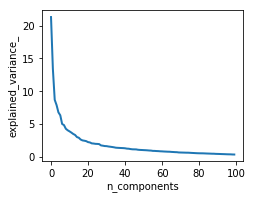

In [22]:
# PCA 
# Plot the PCA spectrum 
pca=PCA(n_components=100)  
pca.fit(X) 
plt.figure(1, figsize=(4, 3)) 
plt.clf() 
plt.axes([.2, .2, .7, .7]) 
plt.plot(pca.explained_variance_, linewidth=2) 
plt.axis('tight') 
plt.xlabel('n_components') 
plt.ylabel('explained_variance_') 
X_reduced = PCA(n_components = 100).fit_transform(X)

### 2.3.1 SVM (RBF) + PCA
SVM (RBF)分类表现更为宽松，且使用PCA降维后的模型表现有明显提升，misclassified多为负向文本被分类为正向文本，其中AUC = 0.92，KSValue = 0.7。

In [23]:
""" 2.1 SVM (RBF) using training data with 20 dimensions """ 

clf = SVC(C = 2, probability = True) 
clf.fit(X_reduced_train, y_reduced_train) 

print ('Test Accuracy: %.2f'% clf.score(X_reduced_test, y_reduced_test) )


Test Accuracy: 0.78


In [24]:
pred_probas = clf.predict_proba(X_reduced_test)[:,1] 

print ("KS value: %f" % ks_2samp(y_reduced_test, pred_probas)[0] )

KS value: 0.530827


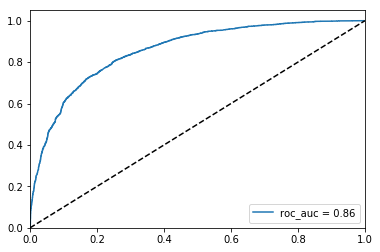

In [26]:
# plot ROC curve # AUC = 0.92 # KS = 0.7 

fpr,tpr,_ = roc_curve(y_reduced_test, pred_probas)
roc_auc =  sklearn.metrics.auc(fpr,tpr)
plt.plot(fpr, tpr, label = 'roc_auc = %.2f' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc = 'lower right')
plt.show()

In [ ]:
joblib.dump(clf, "SVC.pkl")

### 2.3.2 MLP
MLP相比于SVM (RBF)，分类更为严格，PCA降维后对模型准确率影响不大，misclassified多为正向文本被分类为负向，其实是更容易overfitting，原因是语料过少，其实用神经网络未免有些小题大做，AUC = 0.91。

In [27]:
#model defination
model = Sequential() 
model.add(Dense(512, input_dim = 200, init = 'uniform', activation = 'tanh')) 
model.add(Dropout(0.5)) 
model.add(Dense(256, activation = 'relu')) 
model.add(Dropout(0.5)) 
model.add(Dense(128, activation = 'relu')) 
model.add(Dropout(0.5)) 
model.add(Dense(64, activation = 'relu')) 
model.add(Dropout(0.5)) 
model.add(Dense(32, activation = 'relu')) 
model.add(Dropout(0.5)) 
model.add(Dense(1, activation = 'sigmoid')) 
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, input_dim=200, activation="tanh", kernel_initializer="uniform")`
  This is separate from the ipykernel package so we can avoid doing imports until


In [28]:
#model traning
model.fit(X_train, y_train, epochs = 100, batch_size = 16) 


Epoch 1/100
11410/11410 [==============================] - 6s 570us/step - loss: 0.6386 - acc: 0.6649
Epoch 2/100
11410/11410 [==============================] - 6s 554us/step - loss: 0.5674 - acc: 0.7294
Epoch 3/100
11410/11410 [==============================] - 7s 649us/step - loss: 0.5508 - acc: 0.7455
Epoch 4/100
11410/11410 [==============================] - 6s 532us/step - loss: 0.5363 - acc: 0.7530
Epoch 5/100
11410/11410 [==============================] - 5s 477us/step - loss: 0.5278 - acc: 0.7586
Epoch 6/100
11410/11410 [==============================] - 5s 480us/step - loss: 0.5149 - acc: 0.7591
Epoch 7/100
11410/11410 [==============================] - 6s 503us/step - loss: 0.5143 - acc: 0.7599
Epoch 8/100
11410/11410 [==============================] - 5s 476us/step - loss: 0.5036 - acc: 0.7696 1s - l
Epoch 9/100
11410/11410 [==============================] - 6s 534us/step - loss: 0.5017 - acc: 0.7695
Epoch 10/100
11410/11410 [==============================] - 6s 506us/step -

11410/11410 [==============================] - 6s 520us/step - loss: 0.2320 - acc: 0.9104
Epoch 81/100
11410/11410 [==============================] - 6s 492us/step - loss: 0.2369 - acc: 0.9118 0s - loss: 0.2394 - ac
Epoch 82/100
11410/11410 [==============================] - 7s 579us/step - loss: 0.2274 - acc: 0.9092
Epoch 83/100
11410/11410 [==============================] - 7s 623us/step - loss: 0.2291 - acc: 0.9111
Epoch 84/100
11410/11410 [==============================] - 7s 574us/step - loss: 0.2296 - acc: 0.9160
Epoch 85/100
11410/11410 [==============================] - 6s 547us/step - loss: 0.2290 - acc: 0.9119
Epoch 86/100
11410/11410 [==============================] - 6s 508us/step - loss: 0.2270 - acc: 0.9184
Epoch 87/100
11410/11410 [==============================] - 6s 555us/step - loss: 0.2344 - acc: 0.9120
Epoch 88/100
11410/11410 [==============================] - 6s 560us/step - loss: 0.2285 - acc: 0.9131
Epoch 89/100
11410/11410 [==============================] - 6s 

In [30]:
score = model.evaluate(X_test, y_test, batch_size = 16) 
print ('Test accuracy: ', score[1])


7607/7607 [==============================] - 1s 154us/step
Test accuracy:  0.7717891415801236


In [31]:
pred_probas2 = model.predict_proba(X_test)[:,0]
print ("KS value: %f" % ks_2samp(y_test, pred_probas2)[0] )

KS value: 0.530827


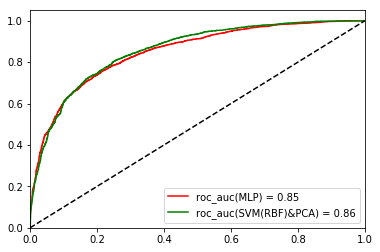

In [32]:
# plot ROC curve # AUC = 0.91 
fpr2,tpr2,_ = roc_curve(y_test, pred_probas2) 
roc_auc2 = sklearn.metrics.auc(fpr2,tpr2) 
plt.plot(fpr2, tpr2, label = 'roc_auc(MLP) = %.2f' % roc_auc2, color="red") 
plt.plot(fpr, tpr, label = 'roc_auc(SVM(RBF)&PCA) = %.2f' % roc_auc, color="green")    # SVM above 
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlim([0.0, 1.0]) 
plt.ylim([0.0, 1.05]) 
plt.legend(loc = 'lower right') 
plt.show()

In [34]:
text = "超好看"
seg_list = jieba.cut(text, cut_all=False)
w2cTest = getWordVecs(list(seg_list))
shapedVector = sum(np.array(w2cTest))/len(w2cTest)
#shapedVector = PCA(n_components = 100).fit_transform()
#np.array([shapedVector])
# scale(w2cTest_reduced)

print(model.predict_proba(np.array([shapedVector]))[0])


[0.0020666]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


## LSTM

In [35]:
EMBEDDING_SIZE = 128
HIDDEN_LAYER_SIZE = 64
data_dim = 200
timesteps = 1

LSTM_model = Sequential()
LSTM_model.add(LSTM(HIDDEN_LAYER_SIZE,input_shape=(timesteps,data_dim), dropout=0.2, recurrent_dropout=0.2))
LSTM_model.add(Dense(1))
LSTM_model.add(Activation("sigmoid"))
LSTM_model.compile(loss="binary_crossentropy", optimizer="adam",metrics=["accuracy"])

In [36]:
X_train_reshaped = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [37]:
LSTM_model.fit(X_train_reshaped, y_train, epochs = 50, batch_size = 16) 
#X_train.shape[0], X_train.shape[1]

Epoch 1/50
11410/11410 [==============================] - 4s 380us/step - loss: 0.5310 - acc: 0.7429
Epoch 2/50
11410/11410 [==============================] - 4s 311us/step - loss: 0.4825 - acc: 0.7692
Epoch 3/50
11410/11410 [==============================] - 4s 333us/step - loss: 0.4600 - acc: 0.7852
Epoch 4/50
11410/11410 [==============================] - 3s 305us/step - loss: 0.4442 - acc: 0.7907
Epoch 5/50
11410/11410 [==============================] - 4s 308us/step - loss: 0.4252 - acc: 0.8035
Epoch 6/50
11410/11410 [==============================] - 4s 308us/step - loss: 0.4115 - acc: 0.8111
Epoch 7/50
11410/11410 [==============================] - 4s 328us/step - loss: 0.3932 - acc: 0.8252
Epoch 8/50
11410/11410 [==============================] - 4s 323us/step - loss: 0.3741 - acc: 0.8337
Epoch 9/50
11410/11410 [==============================] - 4s 329us/step - loss: 0.3614 - acc: 0.8401
Epoch 10/50
11410/11410 [==============================] - 4s 328us/step - loss: 0.3475 - a

In [38]:
score = LSTM_model.evaluate(X_test_reshaped, y_test, batch_size = 16) 
print ('Test accuracy: ', score[1])
pred_probas3 = LSTM_model.predict_proba(X_test_reshaped)[:,0]
print ("KS value: %f" % ks_2samp(y_test, pred_probas3)[0] )

7607/7607 [==============================] - 1s 130us/step
Test accuracy:  0.7519390035571979
KS value: 0.530827


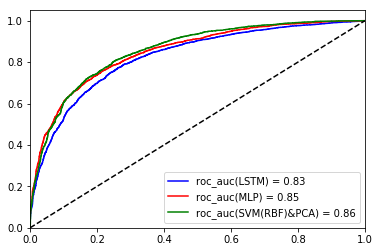

In [39]:
# plot ROC curve # AUC = 0.91 
fpr3,tpr3,_ = roc_curve(y_test, pred_probas3) 
roc_auc3 = sklearn.metrics.auc(fpr3,tpr3) 
plt.plot(fpr3, tpr3, label = 'roc_auc(LSTM) = %.2f' % roc_auc3, color="blue") 
plt.plot(fpr2, tpr2, label = 'roc_auc(MLP) = %.2f' % roc_auc2, color="red") 
plt.plot(fpr, tpr, label = 'roc_auc(SVM(RBF)&PCA) = %.2f' % roc_auc, color="green")    # SVM above 
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlim([0.0, 1.0]) 
plt.ylim([0.0, 1.05]) 
plt.legend(loc = 'lower right') 
plt.show()

In [40]:
text = "我觉得这个电影还不错的，虽然剧情有点牵强，女主设定有点奇怪，男主长的太丑了，其实还是可以一看的，期待下一部，超好看的！！！！！"
seg_list = jieba.cut(text, cut_all=False)
w2cTest = getWordVecs(list(seg_list))
shapedVector = sum(np.array(w2cTest))/len(w2cTest)
shapedVector = np.array([shapedVector]);
reshapedVector = np.reshape(shapedVector, (shapedVector.shape[0], 1, shapedVector.shape[1]))
print(LSTM_model.predict_proba(reshapedVector))

[[0.45008725]]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [41]:
model.save("outputs/MLPmodel.h5")
LSTM_model.save("outputs/LSTMmodel.h5")